# Exercise 4: DCM for fMRI

## Exercise 4.1: Programming a two region DCM

a. writing a function to calculate the right-hand side of the differential equation (1)

In [ ]:
function single_step_neural(x::Vector{Float64}, u::Vector{Float64}, Pneural::Dict{String, Matrix{Float64}})
    u1, u2 = u[1], u[2] # u1 is driving input, u2 is modulating input of 2d input vector u (u1 and u2 are columns) ??
    A = Pneural["A"]    # fixed connectivity matrix
    B = Pneural["B"]    # modulatory connectivity matrix
    C = Pneural["C"]    # driving input matrix??

    # defining connectivity matrix CON
    CON = zeros(2, 2)
    CON[1, 1] = -0.5 * exp(A[1, 1] + u2 * B[1, 1])
    CON[1, 2] = A[1, 2] + u2 * B[1, 2]
    CON[2, 1] = A[2, 1] + u2 * B[2, 1]
    CON[2, 2] = -0.5 * exp(A[2, 2] + u2 * B[2, 2])

    # computing dx/dt
    dx_dt = CON * x + C * [u1, 0.0]
    return dx_dt
end

In [ ]:
# testing 4.1a (this was all chatGPT tbh... but supposedly its gives the expected output)
using LinearAlgebra, Test

A = [0.1 0.2; 0.3 0.4]

B = [0.01 0.02; 0.03 0.04]

C = [1.0 0.0; 0.0 0.0]

Pneural = Dict("A" => A, "B" => B, "C" => C)

x = [1.0, 2.0]
u = [5.0, 1.0]

dx_dt = single_step_neural(x, u, Pneural)
println("dx/dt = ", dx_dt)

b.  writing a function that computes the update for the hemodynamic model of a single region

In [ ]:
function single_step_hrf(h::Vector{Float64}, x::Float64, PHRF::Dict{String, Float64})
    s, f, v, q = h

    # note: in this exercise, fixed values: κ = 0.64, γ = 0.32, τ = 2, α = 0.32 and E0 = 0.4
    k = PHRF["k"]
    y = PHRF["y"]
    t = PHRF["t"]
    a = PHRF["a"]
    E0 = PHRF["E0"]

    println("k = ", k)
    println("y = ", y)
    println("t = ", t)
    println("a = ", a)
    println("E0 = ", E0)

    # getting ds (eq. 4)
    ds = x - k * s - y * (f - 1)
    # getting df (eq. 5)
    df = s
    # getting dv (eq. 6)
    dv = (1 / t) * (f - v^(1 / a))
    # getting dv (eq. 6)
    interm = (1 - (1 - E0)^(1 / f)) / E0
    dq = (1/t) * (f * interm - v^(1 / a) * (q / v))

    return [ds, df, dv, dq]
end


c. writing a function to which uses v and q (rows 3 and 4 in h) to compute the BOLD signal change y (using slide 24)

In [ ]:
function compute_bold_signal(h::Vector{Float64}, PHRF::Dict{String, Float64})
    v = h[3]
    q = h[4]

    # Fixed constants for 3 Tesla
    V0 = 0.04
    E0 = PHRF["E0"]
    e = 0.47
    r0 = 110.0
    theta0 = 80.6
    TE = 0.035

    # equations from slide 24
    k1 = 4.3 * theta0 * E0 * TE
    k2 = e * r0 * E0 * TE
    k3 = 1 - e

    # BOLD signal equation, also from slide 24
    y = V0 * (k1 * (1 - q) + k2 * (1 - (q / v)) + k3 * (1 - v))
    return y
end


d. writing a function which emulates a simple Euler integrator and iterates over all time steps of the input to generate the neural (x), hemodynamic (h) and BOLD (y) traces. 

In [ ]:
function euler_integrate_dcm(U::Dict, Pneural::Dict, PHRF::Dict, x0::Vector{Float64}, h0::Matrix{Float64})
    dt = U["dt"]
    u_matrix = U["u"]
    T = size(u_matrix, 2)

    n_regions = length(x0)  # should be 2
    n_states = size(h0, 1)  # s, f, v, q states for hemodynamics

    x_trace = zeros(n_regions, T)   # neural activity over time of n regions? 
    h_trace = zeros(n_states, n_regions, T)    # hemodynamic states over time of n regions? (look at 4.1b)
    y_trace = zeros(n_regions, T)   # BOLD signal traces of n regions

    # Initial states
    x = copy(x0)
    h = copy(h0)

    # euler integration loops: x+1 = x + dt * (dx/dt)
    for t in 1:T
        u = u_matrix[:, t]

        # updating neural activity
        dxdt = single_step_neural(x, u, Pneural)
        x += dt * dxdt
        x_trace[:, t] = x

        # updating hemodynamics (balloon model slide 23)
        for r in 1:n_regions
            dhdt = single_step_hrf(h[:, r], x[r], PHRF)
            h[:, r] += dt * dhdt
            h_trace[:, r, t] = h[:, r]
        end
    end

    # computing BOLD signal after simulation
    for t in 1:T
        for r in 1:n_regions
            y_trace[r, t] = compute_bold_signal(h_trace[:, r, t], PHRF)
        end
    end

    return y_trace, h_trace, x_trace
end


In [ ]:
dt = 0.1
T = 80.0
time_steps = Int(T / dt)
time = collect(0:dt:(T - dt))

# u1 is driving input of 5 every 7 seconds
u1 = zeros(time_steps)
for t in 1:time_steps
    if mod(time[t], 7.0) < dt
        u1[t] = 5.0
    end
end
# u2 is modulating input (1 for 30-60 seconds, 0 otherwise)
u2 = [((30.0 <= t <= 60.0) ? 1.0 : 0.0) for t in time]

U = Dict("u" => hcat(u1, u2)', "dt" => dt) # putting u1 and u2 into a matrix, then transposing so its 2 × 800

# parameters (from assignment)
A = [0.0 0.0; 1.0 0.0]
B = [0.0 0.0; -0.5 0.0]
C = [1.0 0.0; 0.0 0.0]
Pneural = Dict(
    "A" => A, 
    "B" => B, 
    "C" => C)

# hemodynamic parameters from 1.4b
PHRF = Dict(
    "k" => 0.64, 
    "y" => 0.32, 
    "t" => 2.0, 
    "a" => 0.32, 
    "E0" => 0.4)

x0 = [0.0, 0.0]
h0 = [0.0 0.0; 1.0 1.0; 1.0 1.0; 1.0 1.0]  # 4 hemodynamic states for 2 regions
y, h, x = euler_integrate_dcm(U, Pneural, PHRF, x0, h0)

# Plotting
using Plots

# Create time vector
time = collect(0:U["dt"]:(size(U["u"], 2) - 1) * U["dt"])

# transposing matrices for plotting
u_plot = U["u"]'
x_plot = x'
y_plot = y'

plot(layout = (3, 1), size=(800, 700), legend = :topright)

# input (u1 and u2)
plot!(time, u_plot[:, 1], label="u₁", lw=2, subplot=1)
plot!(time, u_plot[:, 2], label="u₂", lw=2, subplot=1)
ylabel!("Input", subplot=1)
title!("Inputs", subplot=1)

# neural activity (x1 and x2)
plot!(time, x_plot[:, 1], label="x₁", lw=2, subplot=2)
plot!(time, x_plot[:, 2], label="x₂", lw=2, subplot=2)
ylabel!("Neural activity", subplot=2)
title!("Neural Activity", subplot=2)

# BOLD signal (y1 and y2)
plot!(time, y_plot[:, 1], label="y₁", lw=2, subplot=3)
plot!(time, y_plot[:, 2], label="y₂", lw=2, subplot=3)
ylabel!("BOLD signal", subplot=3)
xlabel!("Time (s)", subplot=3)
title!("BOLD Signal", subplot=3)


## Exercise 4.2: Exploring the effect of modulation

a. Run the simulation without modulation

In [ ]:
# Helper function to update B matrix
function run_model_with_B(B::Matrix{Float64})
    Pneural_mod = Dict(
        "A" => A,
        "B" => B,
        "C" => C
    )
    return euler_integrate_dcm(U, Pneural_mod, PHRF, x0, h0)
end

B1 = zeros(2, 2)
y_B1, _, x_B1 = run_model_with_B(B1)

b. Explore the changes in the activity $x$ and the BOLD signal $y$ of region 2 when $b$ value is changed

In [9]:
b_values = [-1.0, -0.5, 0.0, 0.5, 1.0]
results_B2 = Dict()
results_B3 = Dict()

for b in b_values
    # B2: modulation on connection from region 1 to 2
    B2 = [0.0 0.0; b 0.0]
    y, h, x = run_model_with_B(B2)
    results_B2[b] = (y, x)

    # B3: self-modulation of region 2
    B3 = [0.0 0.0; 0.0 b]
    y, h, x = run_model_with_B(B3)
    results_B3[b] = (y, x)
end

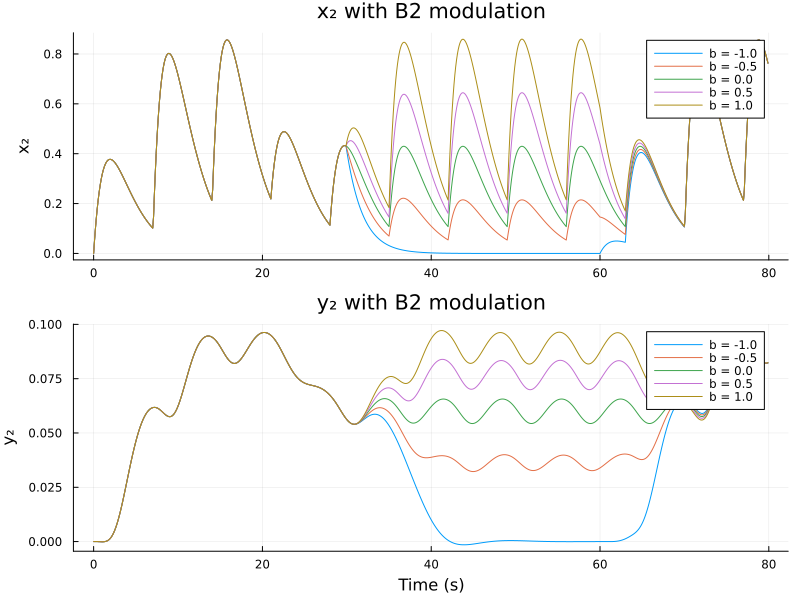

In [10]:
# Plot neural activity x2 for B2
plot(layout=(2, 1), size=(800, 600), legend=:topright)
for b in b_values
    x2 = results_B2[b][2][2, :]  # x2 over time
    plot!(time, x2, label="b = $b", subplot=1)
end
title!("x₂ with B2 modulation", subplot=1)
ylabel!("x₂", subplot=1)

# BOLD signal y2 for B2
for b in b_values
    y2 = results_B2[b][1][2, :]  # y2 over time
    plot!(time, y2, label="b = $b", subplot=2)
end
title!("y₂ with B2 modulation", subplot=2)
ylabel!("y₂", subplot=2)
xlabel!("Time (s)", subplot=2)

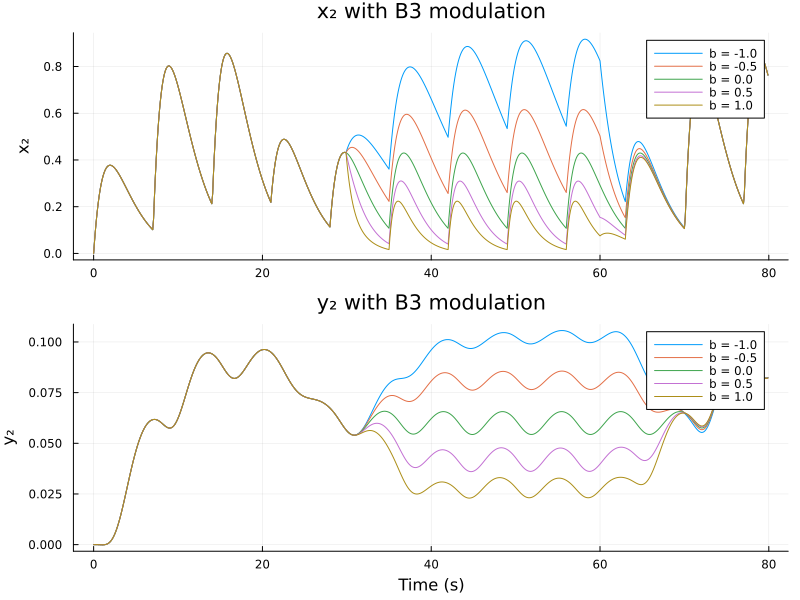

In [11]:
# Plot neural activity x2 for B3
plot(layout=(2, 1), size=(800, 600), legend=:topright)
for b in b_values
    x2 = results_B3[b][2][2, :]
    plot!(time, x2, label="b = $b", subplot=1)
end
title!("x₂ with B3 modulation", subplot=1)
ylabel!("x₂", subplot=1)

# BOLD signal y2 for B3
for b in b_values
    y2 = results_B3[b][1][2, :]
    plot!(time, y2, label="b = $b", subplot=2)
end
title!("y₂ with B3 modulation", subplot=2)
ylabel!("y₂", subplot=2)
xlabel!("Time (s)", subplot=2)

**Observations**:
- Changes in $b$ value are more visible in $B_2$ as they are altering intra-network connectivity
- For $B3$, we're modulating region 2 own self-inhibition, so changes in persistence and decay rate of $x_2$ can be observed
- When $b > 0$, effective connectivity increases, and when $b < 0$, it becomes more inhibitory